Cell explaining briefly what Survival Analysis is and what our goals are in doing this test

## Step 1: Import Data and Dependencies

In [49]:
import pandas as pd
import cptac
import numpy as np
import sksurv
import matplotlib.pyplot as plt
import seaborn as sns
from sksurv.nonparametric import kaplan_meier_estimator
import scipy
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis

In [2]:
en = cptac.Endometrial()
clinical = en.get_clinical()
proteomics = en.get_proteomics()

In [3]:
follow_up = pd.read_excel('../Follow_Up_Data/UCEC_followup_9_12.xlsx')

## Step 2: Data Preparation

In [19]:
#Data Cleaning necessary for the data before it is cleaned by Mathangi

#Get just the discovery cohort
cohort_filter = follow_up['Cohort'] == "Disc"
discovery_cohort = follow_up[cohort_filter]
other_cohort = follow_up[~cohort_filter]

In [20]:
#Determine columns to drop and drop them
cols_to_drop = ['Tumor code', 'ECOG Score', 
                'Karnofsky Score', 'Perform Status Scale: Timing', 
                'Other Perform Scale Timing', 
                'Specify Other New Tumor Site', 'Tamoxifen']

discovery_cohort = discovery_cohort.drop(cols_to_drop, axis=1)

In [21]:
#Drop other unhelpful columns
for col in discovery_cohort.columns:
    if len(discovery_cohort[col].value_counts()) <= 1:
        discovery_cohort = discovery_cohort.drop(col, axis=1)

In [22]:
#Replace things that mess up the analysis       
things_to_replace = ['Not Reported/ Unknown', 'Reported/ Unknown', 
                     'Not Applicable', 'na', 'unknown', 'Not Performed', 
                     'Unknown tumor status', 'Unknown', 
                     'Unknown Tumor Status', 'Not specified']

for col in discovery_cohort.columns:
    discovery_cohort[col] = discovery_cohort[col].replace(things_to_replace, np.nan)

In [23]:
#Rename column to merge on, and then merge follow-up with clinical data
discovery_cohort = discovery_cohort.rename({'Case ID': 'Patient_ID'}, axis='columns')

patient_data = pd.merge(clinical, discovery_cohort, on = 'Patient_ID')

In [24]:
#Determine columns to focus on, and create a subset to work with
columns_to_focus_on = ['Patient_ID', 'Lost to Follow-up?', 'Vital Status', 
                       'Histologic_Grade_FIGO', 'Path Diag to Last Contact(Day)', 
                       'Cause of Death', 'Success of Initial Treatment',
                       'Path Diag to Death(days)', 'Follow-up Period',
                       'Success of Treatment@ Followup', 'Histologic_type', 
                       'New Tumor After Initial TRT',
                       'tumor_Stage-Pathological',
                       'Path Diag to new Tumor (days)', 'BMI']

focus_group = patient_data[columns_to_focus_on].copy().drop_duplicates()

## Step 2b: Prepare data for Kaplan Meier Plotting and Survival Analysis

In [25]:
focus_group.columns

Index(['Patient_ID', 'Lost to Follow-up?', 'Vital Status',
       'Histologic_Grade_FIGO', 'Path Diag to Last Contact(Day)',
       'Cause of Death', 'Success of Initial Treatment',
       'Path Diag to Death(days)', 'Follow-up Period',
       'Success of Treatment@ Followup', 'Histologic_type',
       'New Tumor After Initial TRT', 'tumor_Stage-Pathological',
       'Path Diag to new Tumor (days)', 'BMI'],
      dtype='object')

In [34]:
focus_group_subset = focus_group[['Vital Status', 
                                  'Path Diag to Last Contact(Day)', 
                                  'Histologic_type', 
                                  'tumor_Stage-Pathological']]
focus_group_subset = focus_group_subset.replace('Living', False)
focus_group_subset = focus_group_subset.replace('Deceased', True)
focus_group_subset = focus_group_subset.dropna()

In [35]:
focus_group_subset.head()

,Vital Status,Path Diag to Last Contact(Day),Histologic_type,tumor_Stage-Pathological
0,False,494.0,Endometrioid,Stage I
1,False,717.0,Endometrioid,Stage I
2,False,737.0,Endometrioid,Stage I
6,False,440.0,Endometrioid,Stage IV
7,False,624.0,Endometrioid,Stage IV


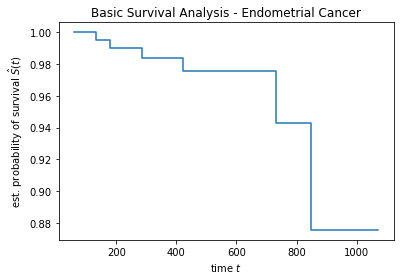

In [36]:
time, survival_prob = kaplan_meier_estimator(focus_group_subset["Vital Status"], 
                                             focus_group_subset["Path Diag to Last Contact(Day)"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title("Basic Survival Analysis - Endometrial Cancer")
plt.show()

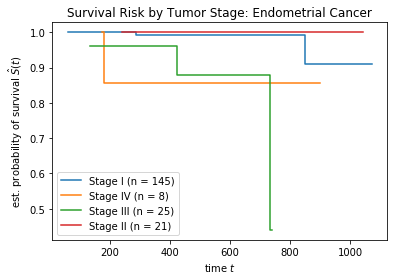

In [37]:
for value in focus_group_subset["tumor_Stage-Pathological"].unique():
    mask = focus_group_subset["tumor_Stage-Pathological"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(focus_group_subset["Vital Status"][mask],
                                                           focus_group_subset["Path Diag to Last Contact(Day)"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.title("Survival Risk by Tumor Stage: Endometrial Cancer")
plt.show()

## Separate the data we are looking at from the vital status and time to last contact, and then create a Structured Array for Vital Status and Time to last contact

In [40]:
tumor_stage_data = focus_group_subset[["tumor_Stage-Pathological", 
                                       "Histologic_type"]].copy()
survival_data = focus_group_subset[['Vital Status', 
                                    "Path Diag to Last Contact(Day)"]].copy()

survival_array = np.zeros(len(survival_data),
                          dtype={"names":("Vital Status",
                                          "Path Diag to Last Contact(Day)"),
                                 "formats":("?", "<f8")})

survival_array['Vital Status'] = survival_data['Vital Status'].values
survival_array['Path Diag to Last Contact(Day)'] = survival_data['Path Diag to Last Contact(Day)'].values 

In [44]:
for col in tumor_stage_data.columns:
    tumor_stage_data[col] = tumor_stage_data[col].astype("category")

In [45]:
tumor_stage_numeric = OneHotEncoder().fit_transform(tumor_stage_data)

## Step 4: Perform Cox Proportional Hazard Test

In [47]:
tumor_stage_numeric.columns

Index(['tumor_Stage-Pathological=Stage II',
       'tumor_Stage-Pathological=Stage III',
       'tumor_Stage-Pathological=Stage IV', 'Histologic_type=Serous'],
      dtype='object')

In [50]:
estimator = CoxPHSurvivalAnalysis()
encoder = OneHotEncoder()
estimator.fit(encoder.fit_transform(tumor_stage_numeric), survival_array)
estimator.fit(tumor_stage_numeric, survival_array)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, ties='breslow', tol=1e-09, verbose=0)

In [51]:
pd.Series(estimator.coef_, index=tumor_stage_numeric.columns)

tumor_Stage-Pathological=Stage II    -17.172620
tumor_Stage-Pathological=Stage III     2.645658
tumor_Stage-Pathological=Stage IV      2.133920
Histologic_type=Serous                 0.924873
dtype: float64

In [54]:
estimator.score(tumor_stage_numeric, survival_array)

0.7997198879551821